In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

In [8]:
# 2. Set Paths and Parameters
train_dir = '/workspaces/Emotion_detector/Data/Maheshi/processed_images/train'
val_dir = '/workspaces/Emotion_detector/Data/Maheshi/processed_images/validation'
img_size = (48, 48)
batch_size = 32
num_classes = 7  # Adjust if your dataset has a different number of classes

In [9]:
# 3. Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 28806 images belonging to 7 classes.
Found 7062 images belonging to 7 classes.
Found 7062 images belonging to 7 classes.


In [10]:
# 4. Build ResNet Model

input_shape = (48, 48, 1)
inputs = Input(shape=input_shape)

# Convert grayscale to 3 channels for ResNet
x = Concatenate()([inputs, inputs, inputs])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.trainable = False  # Freeze base model

x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 48, 48, 3) │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2, 2,      │ 23,587,712 │ concatenate[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │        903 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
# 5. Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15
)

/opt/conda/envs/ml-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 321s 351ms/step - accuracy: 0.2269 - loss: 1.8599 - val_accuracy: 0.2584 - val_loss: 1.8073
Epoch 2/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 321s 351ms/step - accuracy: 0.2269 - loss: 1.8599 - val_accuracy: 0.2584 - val_loss: 1.8073
Epoch 2/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 303s 336ms/step - accuracy: 0.2484 - loss: 1.8154 - val_accuracy: 0.2584 - val_loss: 1.8001
Epoch 3/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 303s 336ms/step - accuracy: 0.2484 - loss: 1.8154 - val_accuracy: 0.2584 - val_loss: 1.8001
Epoch 3/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 315s 350ms/step - accuracy: 0.2499 - loss: 1.8086 - val_accuracy: 0.2584 - val_loss: 1.8072
Epoch 4/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 315s 350ms/step - accuracy: 0.2499 - loss: 1.8086 - val_accuracy: 0.2584 - val_loss: 1.8072
Epoch 4/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 335s 372ms/step - accuracy: 0.2499 - loss: 1.8027 - val_accuracy: 0.2586 - val_loss: 1.7913
Epoch 5/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 335s 372ms/step - accuracy: 0.2499 -

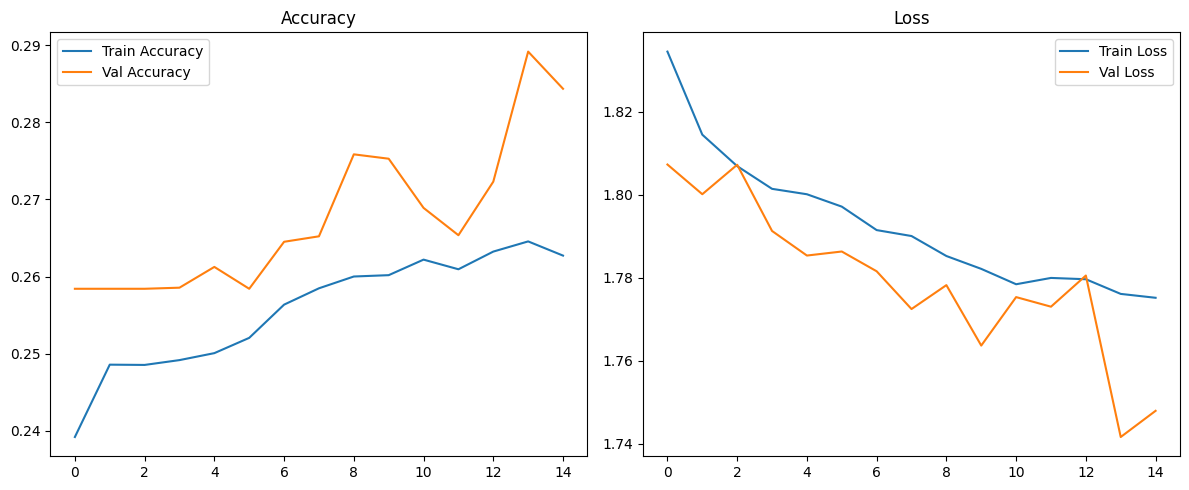

In [12]:
# 6. Visualize Training Results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Found 28806 images belonging to 7 classes.
Epoch 1/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 484s 529ms/step - accuracy: 0.2456 - loss: 1.8440 - val_accuracy: 0.2584 - val_loss: 1.8026
Epoch 2/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 472s 523ms/step - accuracy: 0.2506 - loss: 1.8023 - val_accuracy: 0.2635 - val_loss: 1.7855
Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 465s 516ms/step - accuracy: 0.2575 - loss: 1.7891 - val_accuracy: 0.2734 - val_loss: 1.7683
Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 451s 500ms/step - accuracy: 0.2608 - loss: 1.7840 - val_accuracy: 0.2887 - val_loss: 1.7711
Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 436s 484ms/step - accuracy: 0.2600 - loss: 1.7790 - val_accuracy: 0.2811 - val_loss: 1.7479
Epoch 6/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 456s 506ms/step - accuracy: 0.2720 - loss: 1.7652 - val_accuracy: 0.2213 - val_loss: 1.8758
Epoch 7/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 444s 493ms/step - accuracy: 0.2726 - loss: 1.7655 - val_accuracy: 0.2782 - val_loss: 1.7708
Epoch 8/10
901/901 ━━━━━━━━━━━━━━

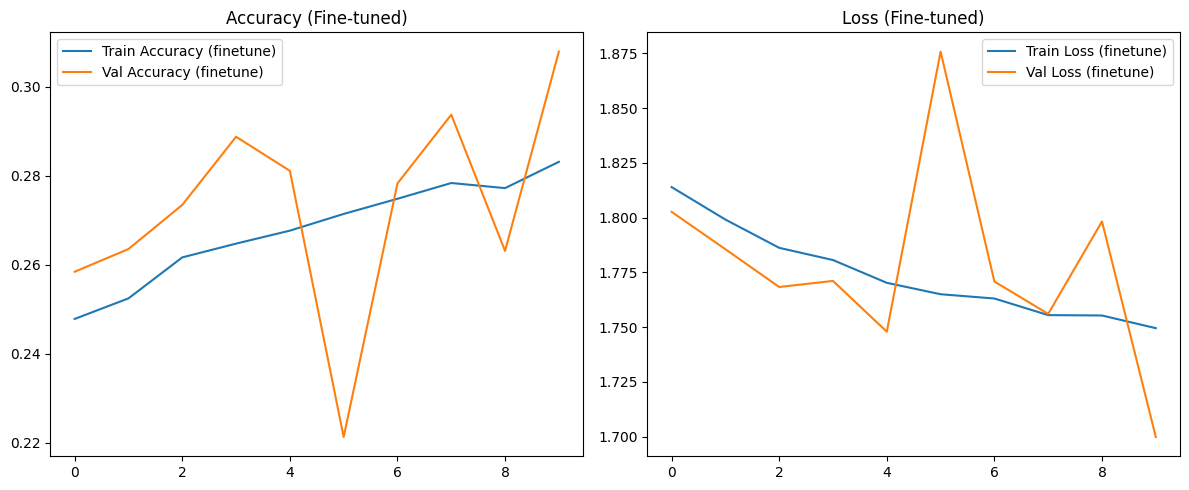

In [ ]:
# 7. Improve Model: Unfreeze some layers and use data augmentation

# Unfreeze last few layers of ResNet for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile model with lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation for training
aug_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
aug_train_data = aug_train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Retrain model with augmentation and fine-tuning
history_finetune = model.fit(
    aug_train_data,
    validation_data=val_data,
    epochs=10
)

# Visualize improved training results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy (finetune)')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy (finetune)')
plt.title('Accuracy (Fine-tuned)')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_finetune.history['loss'], label='Train Loss (finetune)')
plt.plot(history_finetune.history['val_loss'], label='Val Loss (finetune)')
plt.title('Loss (Fine-tuned)')
plt.legend()
plt.tight_layout()
plt.show()